## Table of Contents

#### Set-Up
- [Splitting the data](#split)
- [Adjusting some features](#adjusting)
- [Clustering](#clustering)
- [Modeling guidelines](#modeling_guidelines)

#### Modeling
- [Random Forest](#rf)
    - [Random Forest with clustering](#rf_cluster)
    - [Two-Stage Random Forest](#two_stage_rf)
    - [Two-Stage Random Forest with clustering](#two_stage_rf_cluster)
    
- [Performance Results](#performance)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
import h2o
from subprocess import call
from IPython.display import Image
from graphviz import render
from bs4 import BeautifulSoup
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import precision_recall_fscore_support, log_loss, r2_score, mean_squared_error, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.1+12-LTS-39, mixed mode, sharing)
  Starting server from C:\Users\Owner\anaconda3\envs\SecondCapstone\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Owner\AppData\Local\Temp\tmpfi5zt7o7
  JVM stdout: C:\Users\Owner\AppData\Local\Temp\tmpfi5zt7o7\h2o_Owner_started_from_python.out
  JVM stderr: C:\Users\Owner\AppData\Local\Temp\tmpfi5zt7o7\h2o_Owner_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 17 days
H2O_cluster_name:,H2O_from_python_Owner_1d87s4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.986 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')
pokemon_data = pd.read_csv('./data/pokemon_data.csv', index_col="name")

In [3]:
pokemon_data

,hp,atk,def,spa,spd,spe,weight,height,formats,generation,...,Ability Cutoff 2,Ability Cutoff 3,Ability Cutoff 4,Ability Cutoff 5,Ability Cutoff 6,Best Ability,Best Ability <100,Unique Powerful Ability,oldformats,oldformat codes
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Ivysaur,60,62,63,80,80,60,13.0,1.0,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Venusaur,80,82,83,100,100,80,100.0,2.0,OU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,UU,4
Charmander,39,52,43,60,50,65,8.5,0.6,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
Charmeleon,58,64,58,80,65,80,19.0,1.1,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,800.0,2.2,NU,SS,...,1.0,1.0,1.0,0.0,0.0,75.000000,75.000000,0,NU,2
Spectrier,100,65,60,145,80,130,44.5,2.0,Uber,SS,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1,Uber,6
Calyrex,100,80,80,80,80,80,7.7,1.1,PU,SS,...,0.0,0.0,0.0,0.0,0.0,18.181818,18.181818,0,ZU,0


<a id="split"></a>
### Splitting the Data

In [4]:
pokemon_data.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height', 'formats',
       'generation', 'format codes', 'Weaknesses', 'Strong Weaknesses',
       'Resists', 'Strong Resists', 'Immune', 'STAB', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 1',
       'Physical Cutoff 2', 'Physical Cutoff 3', 'Physical Cutoff 4',
       'Physical Cutoff 5', 'Physical Cutoff 6', 'Physical Coverage 1',
       'Physical Coverage 2', 'Physical Coverage 3', 'Physical Coverage 4',
       'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 3',
       'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6',
       'Special Cutoff 7', 'Special Coverage 1', 'Special Coverage 2',
       'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 5',
       'Special Coverage 6', 'Special Coverage 7', 'Special Cove

In [5]:
X = pokemon_data.drop(columns=['weight', 'height', 'Weaknesses', 'Strong Weaknesses', 'Resists',
                                'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2',
                                'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6',
                                'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4',
                                'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4',
                                'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7',
                                'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3',
                                'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7',
                                'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10',
                                'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5',
                                'Ability Cutoff 6', 'Best Ability <100', 'formats', 'generation',
                                'format codes', 'oldformats', 'oldformat codes'])

y_df = pd.DataFrame(pokemon_data[['formats', 'format codes']], index=pokemon_data.index, columns=['formats', 'format codes', 'oldformats', 'oldformat codes'])
y_df['formats4'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['format codes4'] = y_df['format codes'].replace({3:2, 4: 2, 5:3, 6:3})
y_df['formats4alt'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'Mid c', 'Uber': 'High c'})
y_df['format codes4alt'] = y_df['format codes'].replace({3:2, 4: 2, 5:2, 6:3})
y_df['formats2'] = y_df['formats'].replace({'ZU':'No', 'PU': 'Yes', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df

,formats,format codes,oldformats,oldformat codes,formats4,format codes4,formats4alt,format codes4alt,formats2
name,,,,,,,,,
Bulbasaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Ivysaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Venusaur,OU,5,NaN,NaN,High c,3,Mid c,2,Yes
Charmander,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Charmeleon,ZU,0,NaN,NaN,Not c,0,Not c,0,No
...,...,...,...,...,...,...,...,...,...
Glastrier,NU,2,NaN,NaN,Mid c,2,Mid c,2,Yes
Spectrier,Uber,6,NaN,NaN,High c,3,High c,3,Yes
Calyrex,PU,1,NaN,NaN,Low c,1,Low c,1,Yes


<a id="adjusting"></a>
### Adjusting some features

- remove: ability cutoff, unique powerful ability

In [6]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Ability Cutoff 3',
       'Best Ability', 'Unique Powerful Ability'],
      dtype='object')

In [7]:
X.drop(columns=['Ability Cutoff 3', 'Unique Powerful Ability'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Recovery,Weather Set,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,1,0,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,0,2,3,3,9,4,3,0,18.181818


In [8]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Best Ability'],
      dtype='object')

- fold weather set into weather gimmick

In [9]:
X['Weather Gimmick'].value_counts()

2    289
1    171
0    161
5     70
3     40
4      7
Name: Weather Gimmick, dtype: int64

In [10]:
X['Weather Set'].value_counts()

0    709
1     29
Name: Weather Set, dtype: int64

In [11]:
X.loc[X['Weather Set'] == 1, 'Weather Gimmick'] = 6
X['Weather Gimmick'].value_counts()

2    265
1    167
0    161
5     70
3     39
6     29
4      7
Name: Weather Gimmick, dtype: int64

In [12]:
X.drop(columns=['Weather Set'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,HP Recovery,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,2,1,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,0,2,3,3,9,4,3,0,18.181818


- fold hp drain and hp recovery together into a recovery feature

In [13]:
X['HP Recovery'].value_counts()

0    517
1    184
2     37
Name: HP Recovery, dtype: int64

In [14]:
X['HP Drain'].value_counts()

0    482
2    202
1     49
3      4
4      1
Name: HP Drain, dtype: int64

In [15]:
X.loc[X['HP Recovery'] == 1, 'HP Drain'] = 3
X.loc[X['HP Recovery'] == 2, 'HP Drain'] = 4
X['HP Drain'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Drain, dtype: int64

In [16]:
X.drop(columns=['HP Recovery'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,3,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,2,3,3,9,4,3,0,18.181818


In [17]:
X['HP Recovery'] = X['HP Drain']
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,3,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,2,3,3,9,4,3,0,18.181818,2


In [18]:
X.drop(columns=['HP Drain'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,3,3,9,4,3,0,18.181818,2


In [19]:
X['HP Recovery'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Recovery, dtype: int64

- considering: removal deterrent (could arguably just remove since its abilities), hazard removal, cleric, entry hazards (all 3 of those might go into misc status)

In [20]:
X.drop(columns=['Removal Deterrent'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Cleric,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,1,...,0,2,3,3,9,4,3,0,18.181818,2


In [21]:
X['Misc Status'].value_counts()

3    335
2    234
1     89
0     41
4     35
5      4
Name: Misc Status, dtype: int64

In [22]:
X['Hazard Removal'].value_counts()

0    558
1    174
2      6
Name: Hazard Removal, dtype: int64

In [23]:
X.loc[X['Hazard Removal'] == 1, 'Misc Status'] = 4
X['Misc Status'].value_counts()

3    249
4    205
2    185
1     63
0     32
5      4
Name: Misc Status, dtype: int64

In [24]:
X.drop(columns=['Hazard Removal'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,1,0,...,0,2,3,3,9,4,3,0,18.181818,2


I'll just leave the other one's (Cleric and Entry Hazards) alone for now, updating them would be complicated and it's probably not even a good idea since they performed better than Hazard Removal

<a id="clustering"></a>
### Clustering

In [25]:
cluster_dfs = {}

n_clusters = list(range(5, 35, 5))
n_clusters

[5, 10, 15, 20, 25, 30]

The number of clusters we'll test in each model that uses clusters, which is only half of them, and we'll want to remember to convert those clusters to categories.

We are going to do clustering of 4 different subsets of features, as we did during EDA:
- one for overall features (scaled)
- one for stats (scaled)
- one for abilities (not scaled, because abilities are one-hot encoded)
- one for learnsets (not scaled, because learnsets are one-hot encoded)

Then we'll make 6 dataframes for each of the different amount of clusters, each with all of those 4 types, and they will go in the cluster_dfs dictionary

In [26]:
cluster5 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[5] = cluster5

In [27]:
cluster10 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[10] = cluster10

In [28]:
cluster15 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[15] = cluster15

In [29]:
cluster20 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[20] = cluster20

In [30]:
cluster25 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[25] = cluster25

In [31]:
cluster30 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[30] = cluster30

In [32]:
cluster_dfs

{5:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              0      1          2          1
 Ivysaur                1      1          2          1
 Venusaur               2      3          2          1
 Charmander             0      1          0          2
 Charmeleon             1      4          0          2
 ...                  ...    ...        ...        ...
 Glastrier              3      0          0          3
 Spectrier              1      3          0          3
 Calyrex                2      2          0          1
 Calyrex-Ice            4      0          0          1
 Calyrex-Shadow         4      3          0          1
 
 [738 rows x 4 columns],
 10:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              3      5          1          3
 Ivysaur                9      9          1          3
 Venusaur               9      

<a id="modeling_guidelines"></a>
### Modeling guidelines

How many models am I making:

one-stage: (3 + 1) x 2, 8 one-stage models: 7 class no clusters, 4 class no clusters, 4 class modified no clusters, 2 class no clusters, then each with clusters

two-stage: (2 + 1) x 2, 6 two-stage models: 7 class no clusters, 4 class no clusters, 4 class modified no clusters, then each with clusters

14 total models for each modeling type

Modeling types: Logistic Regression, KNN, Decision Tree, Random Forest, CatBoost

Extra considerations:

- For Logistic Regression and KNN we will need to scale our features.

- We might not even bother with clustering using something like logistic regression, though we can look up whether it might be worthwhile

- Metric will be weighted F1 score, there is no well developed ROC curve for multi-class, log loss is not good for unbalanced classes, F1 score weighted should be especially appropriate for unbalanced classes and where we don't care more about precision or recall (there is no greater cost to a false positive or false negative for our problem)

In [33]:
k_list = [2, 3, 5, 10]

cluster_types = list(cluster_dfs[5].columns)

<a id="rf"></a>
### Random Forest

In [34]:
param_grid = {
    'balance_classes': [False, True],
    'ntrees': [64, 128],
    'max_depth': [5, 10],
    'min_rows': [5, 10],
    'nbins': [10, 20]}

param_grid

{'balance_classes': [False, True],
 'ntrees': [64, 128],
 'max_depth': [5, 10],
 'min_rows': [5, 10],
 'nbins': [10, 20]}

#### 7 classes, no clusters

In [35]:
rf_grid_dict = {}

for k in k_list:
    #I don't like the h2o version of train_test_split
    #it doesn't offer stratify, so we're just using sklearn
    X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
    
    #merging features with target variable since that's the format h2o uses
    data = X_train.merge(y_train, on='name')
    
    #making pokemon name a column so that we can track it later
    #becasue h2o frames don't keep row indexes, they are only numerical
    #it will be dropped during training, after the train test split
    data['name'] = data.index
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data = data[cols]
    
    data_h2 = h2o.H2OFrame(data)

    #turn the one-hot encoded unique powerful moves, and our target variable...
    #...into categoricals
    data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
    data_h2['formats'] = data_h2['formats'].asfactor()
    
    rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
    rf_grid.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2, seed=273, nfolds=k, fold_assignment="Stratified")
    
    rf_grid_dict[k] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [36]:
best = []
best_params = []

for k in k_list:
    best_model = []
    for model in rf_grid_dict[k]:
        data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats']))[0]
        data_result = data_h2.as_data_frame()
        best_model.append(f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted'))
    best.append(max(best_model))
    best_params.append(best_model.index(max(best_model)))
    
max(best), k_list[best.index(max(best))], best_params[best.index(max(best))]

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9580047843741822, 2, 30)

In [37]:
best_model_7 = rf_grid_dict[2][30]
data_h2['prediction'] = best_model_7.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9580047843741822

In [38]:
rf_grid_dict[2]

     balance_classes  max_depth  min_rows  nbins  ntrees  \
0              false       10.0       5.0   20.0   128.0   
1              false       10.0       5.0   10.0   128.0   
2              false       10.0       5.0   20.0    64.0   
3              false       10.0       5.0   10.0    64.0   
4              false        5.0       5.0   10.0   128.0   
5              false        5.0       5.0   20.0   128.0   
6              false        5.0       5.0   20.0    64.0   
7              false        5.0       5.0   10.0    64.0   
8              false       10.0      10.0   20.0   128.0   
9              false       10.0      10.0   10.0   128.0   
10             false        5.0      10.0   20.0   128.0   
11             false        5.0      10.0   10.0   128.0   
12             false       10.0      10.0   20.0    64.0   
13             false       10.0      10.0   10.0    64.0   
14             false        5.0      10.0   20.0    64.0   
15             false        5.0      10.

In [39]:
best_model_7.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,64.0,448.0,296381.0,8.0,10.0,9.941964,26.0,84.0,47.921875


This model has the following parameters that we set:
- cross validation folds: 2
- balance classes: True
- ntrees: 64
- max_depth: 10
- min_rows/min_leaves: 26 (the min was actually set to other values but perhaps it just turned out as 26 in practice since it never reached the minimum that we set), the real min looks to have been 5 so I might not need this parameter in the future
- nbins: 20

In [40]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.93233083, 0.95412844, 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 array([0.98804781, 0.87394958, 0.90322581, 0.97142857, 1.        ,
        0.97674419, 1.        ]),
 array([0.95938104, 0.9122807 , 0.94915254, 0.98550725, 1.        ,
        0.98823529, 1.        ]),
 array([251, 119,  31,  35,  34,  43,  40], dtype=int64))

The good news is that this is by far the best model I've seen yet. It's not so accurate that it is definitely overfitting, though it might be overfitting, but the accuracy is very high in all classes (though the test data might tell a different story later).

With accuracies this high in seven classes, it calls into question the point of using 4 class models at all, and since these random forests take a long time to train, I think I'm going to skip 4 class models. We still need to train 2 class models, however, if we want to do a two-stage model.

In [41]:
data_result.loc[data_result['formats'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,formats,prediction
0,Tangela,65,55,115,100,40,60,-1,0,0,...,3,2,4,3,4,0,100.000000,4,PU,ZU
18,Kadabra,40,35,30,120,70,105,-1,0,0,...,7,9,9,6,3,0,100.000000,3,PU,ZU
38,Silvally-Grass,95,95,95,95,95,95,-1,0,0,...,10,7,14,9,4,1,100.000000,0,ZU,PU
78,Silvally-Poison,95,95,95,95,95,95,3,0,0,...,10,7,14,9,4,1,100.000000,0,PU,ZU
102,Haunter,45,50,45,115,55,95,10,0,0,...,7,7,12,8,3,0,95.454545,2,PU,ZU
144,Roselia,50,60,45,100,80,65,2,3,1,...,4,3,6,6,4,0,100.000000,3,PU,ZU
167,Pikachu,35,55,40,50,50,90,2,0,1,...,7,7,5,3,3,0,70.000000,1,PU,ZU
239,Pawniard,45,85,70,40,40,60,13,2,0,...,6,6,4,2,3,0,88.888889,0,PU,ZU
251,Lopunny,65,76,84,54,96,105,3,0,2,...,10,9,9,5,3,0,16.666667,2,ZU,PU
259,Swoobat,67,57,55,77,55,114,3,0,0,...,7,3,8,5,4,0,50.000000,3,PU,ZU


It looks like the only drastically wrong predictions are Redidrago and especially Rotom-Heat. That's unfortunate, but overall it's quite a good result.

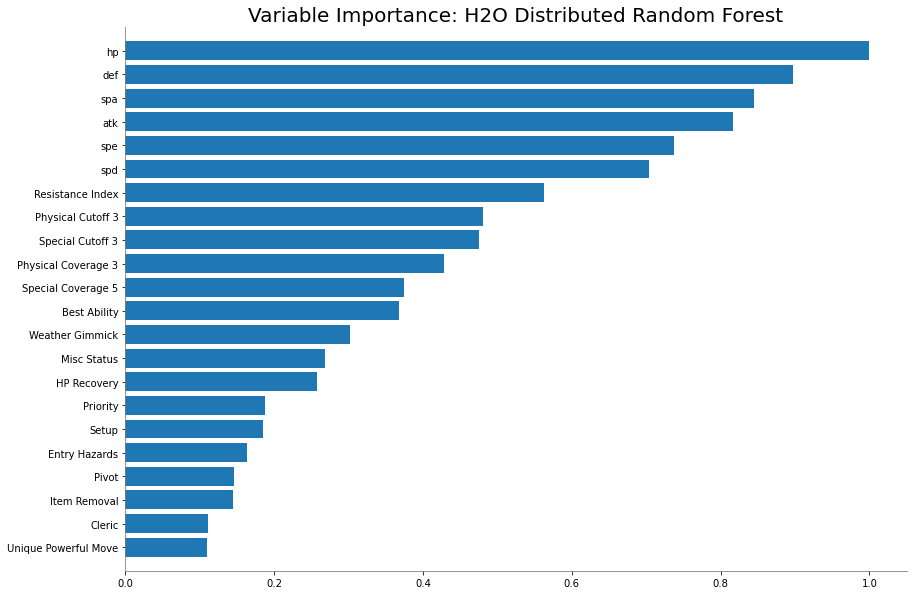

In [42]:
best_model_7.varimp_plot(22)

This is a pretty sensible set of feature importances, with stats, type information, move information, ability information, etc. being the highest, then important features like weather gimmick and misc status also come out as important, and more niche features like item removal, cleric and unique powerful moves are relatively low (but still significant contributers compared to what we saw during the EDA)

#### 2 class no clusters

In [43]:
rf_grid_dict = {}

for k in k_list:
    #I don't like the h2o version of train_test_split
    #it doesn't offer stratify, so we're just using sklearn
    X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
    
    #merging features with target variable since that's the format h2o uses
    data = X_train.merge(y_train, on='name')
    
    #making pokemon name a column so that we can track it later
    #becasue h2o frames don't keep row indexes, they are only numerical
    #it will be dropped during training, after the train test split
    data['name'] = data.index
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data = data[cols]
    
    data_h2 = h2o.H2OFrame(data)

    #turn the one-hot encoded unique powerful moves, and our target variable...
    #...into categoricals
    data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
    data_h2['formats2'] = data_h2['formats2'].asfactor()
    
    rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
    rf_grid.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2, seed=273, nfolds=k, fold_assignment="Stratified")
    
    rf_grid_dict[k] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [44]:
best = []
best_params = []

for k in k_list:
    best_model = []
    for model in rf_grid_dict[k]:
        data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats2']))[0]
        data_result = data_h2.as_data_frame()
        best_model.append(f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted'))
    best.append(max(best_model))
    best_params.append(best_model.index(max(best_model)))
    
max(best), k_list[best.index(max(best))], best_params[best.index(max(best))]

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9417868312618772, 2, 4)

Interestingly, this is lower f score than the 7 class model, though since that's just on the training data, I'm not sure I'd rule out using a two stage model yet. It is still a higher f score than I've ever received in other models before.

Also, 2 fold cross validation won again, so that's probably the only type of cross-validation I'll be using to train my models which use clustering, since otherwise the training time will be too large to test different cross validation fold sizes.

In [45]:
best_model_2 = rf_grid_dict[2][4]
data_h2['prediction'] = best_model_2.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9417868312618772

In [46]:
rf_grid_dict[2]

     balance_classes  max_depth  min_rows  nbins  ntrees  \
0              false       10.0       5.0   10.0   128.0   
1              false       10.0       5.0   10.0    64.0   
2              false       10.0       5.0   20.0    64.0   
3              false       10.0       5.0   20.0   128.0   
4               true       10.0       5.0   20.0   128.0   
5               true       10.0       5.0   10.0   128.0   
6               true       10.0       5.0   20.0    64.0   
7              false        5.0       5.0   10.0   128.0   
8              false        5.0       5.0   20.0   128.0   
9               true       10.0       5.0   10.0    64.0   
10             false        5.0       5.0   20.0    64.0   
11              true        5.0       5.0   20.0   128.0   
12             false        5.0       5.0   10.0    64.0   
13              true        5.0       5.0   10.0   128.0   
14              true        5.0       5.0   20.0    64.0   
15              true        5.0       5.

In [47]:
best_model_2.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,128.0,128.0,66294.0,7.0,10.0,9.109375,28.0,44.0,36.429688


This model has the following parameters that we set:
- cross validation folds: 2
- balance classes: True
- ntrees: 128
- max_depth: 10
- min_rows/min_leaves: 28 (the min was actually set to other values but perhaps it just turned out as 26 in practice since it never reached the minimum that we set), the real min used was 5 so I might not need this parameter in the future, or I can just set it to one value
- nbins: 20

So the only parameter which is inconsistent between the two models is ntrees, so that's the only one I will need in my param_grid when testing my clustering based models. The other values I'll set to the specific parameters of all of my best models.

In [48]:
precision_recall_fscore_support(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'])

(array([0.98237885, 0.91411043]),
 array([0.88844622, 0.98675497]),
 array([0.93305439, 0.94904459]),
 array([251, 302], dtype=int64))

In [49]:
data_result.loc[data_result['formats2'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,formats2,prediction
12,Beartic,95,130,80,70,80,50,-3,0,0,...,12,8,5,4,2,0,100.000000,0,No,Yes
37,Krokorok,60,82,45,45,45,74,6,2,0,...,8,7,6,4,2,0,75.000000,0,Yes,No
58,Dusclops,40,70,130,60,130,25,8,0,0,...,7,8,8,5,3,0,65.217391,0,No,Yes
78,Wishiwashi,45,20,20,25,25,40,2,0,0,...,4,4,4,3,1,0,1.000000,0,Yes,No
84,Regigigas,110,160,110,80,110,100,3,0,0,...,16,10,4,4,3,0,0.000000,2,No,Yes
90,Glalie,80,80,80,80,80,80,-3,3,0,...,8,5,6,4,3,0,26.315789,0,No,Yes
106,Silvally-Grass,95,95,95,95,95,95,-1,0,0,...,10,7,14,9,4,1,100.000000,0,No,Yes
133,Silvally-Psychic,95,95,95,95,95,95,-1,0,0,...,10,7,14,9,4,1,100.000000,0,No,Yes
135,Octillery,75,105,75,105,75,45,2,0,0,...,7,5,13,8,3,0,50.000000,0,No,Yes
147,Gourgeist-Large,75,95,122,58,75,69,7,0,0,...,8,5,12,9,3,0,50.000000,3,No,Yes


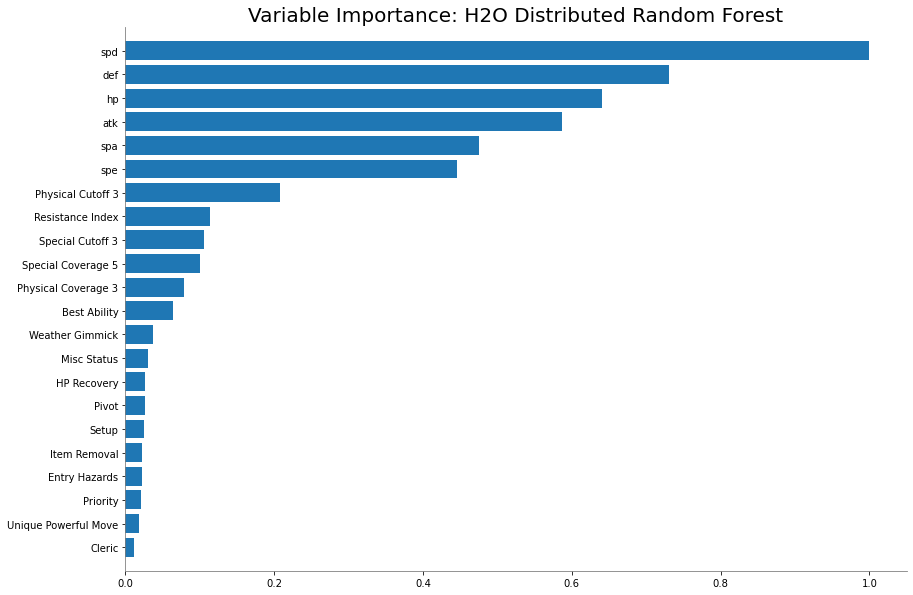

In [50]:
best_model_2.varimp_plot(22)

This is MUCH more heavily weighted towards stats than the 7 class model is.

<a id="rf_cluster"></a>
#### Random Forest with clustering

In [51]:
param_grid = {'ntrees': [64, 128]}

param_grid

{'ntrees': [64, 128]}

#### 7 class with clustering

In [52]:
rf_grid_dict = {}

#sets up the nested dictionary structure
for n in n_clusters:
    rf_grid_dict[n] = {}

for n in n_clusters:
    for c_type in cluster_types:
        #merging the clusters into the data
        X_final = pd.merge(X, cluster_dfs[n][c_type], on='name')
        
        #I don't like the h2o version of train_test_split
        #it doesn't offer stratify, so we're just using sklearn
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
        
        #merging features with target variable since that's the format h2o uses
        data = X_train.merge(y_train, on='name')
        
        #making pokemon name a column so that we can track it later
        #becasue h2o frames don't keep row indexes, they are only numerical
        #it will be dropped during training, after the train test split
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        
        data_h2 = h2o.H2OFrame(data)
        
        #turn the one-hot encoded unique powerful moves, and our target variable...
        #...into categoricals
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        
        rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
        rf_grid.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)
    
        rf_grid_dict[n][c_type] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

That actually didn't take long at all, maybe just a minute or two, which may be a good sign for my ability to run this notebook from start to finish again if I want to.

In [53]:
best = (0, 0, 0, 0)

for n in n_clusters:
    for c_type in cluster_types:
        count = 0
        ##remake the data_h2 again for each n and c_type
        X_final = pd.merge(X, cluster_dfs[n][c_type], on='name')
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
        data = X_train.merge(y_train, on='name')
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        data_h2 = h2o.H2OFrame(data)
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        for model in rf_grid_dict[n][c_type]:
            data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats']))[0]
            data_result = data_h2.as_data_frame()
            score = f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')
            if score > best[0]:
                best = (score, n, c_type, count)
            count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.972750638800639, 15, 'stats', 1)

The stats clusters won with a total of 15 clusters, and the accuracy of this model is very high indeed

In [54]:
best_model_7_cluster = rf_grid_dict[15]['stats'][1]

##remake the data_h2 again for 15 stats clusters
X_final = pd.merge(X, cluster_dfs[15]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

data_h2['prediction'] = best_model_7_cluster.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.972750638800639

In [55]:
rf_grid_dict[15]['stats']

     ntrees  \
0     128.0   
1      64.0   

                                                            model_ids  \
0  Grid_DRF_py_562_sid_8f98_model_python_1640412025079_136594_model_2   
1  Grid_DRF_py_562_sid_8f98_model_python_1640412025079_136594_model_1   

    logloss  
0  1.430829  
1  1.594989  


In [56]:
best_model_7_cluster.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,64.0,448.0,283790.0,8.0,10.0,9.908483,18.0,79.0,45.691963


This model has 64 trees, which seems to be the case for 7 class models here. Let's see which one's were wrong:

In [57]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.95752896, 0.96491228, 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 array([0.98804781, 0.92436975, 0.93548387, 1.        , 1.        ,
        0.97674419, 1.        ]),
 array([0.97254902, 0.94420601, 0.96666667, 1.        , 1.        ,
        0.98823529, 1.        ]),
 array([251, 119,  31,  35,  34,  43,  40], dtype=int64))

In [58]:
data_result.loc[data_result['formats'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,stats,formats,prediction
38,Silvally-Grass,95,95,95,95,95,95,-1,0,0,...,7,14,9,4,1,100.000000,0,11,ZU,PU
58,Metang,60,75,100,55,80,50,10,2,0,...,8,7,5,3,0,64.285714,0,1,PU,ZU
78,Silvally-Poison,95,95,95,95,95,95,3,0,0,...,7,14,9,4,1,100.000000,0,11,PU,ZU
108,Sableye,50,75,75,65,65,50,12,0,0,...,10,8,5,3,0,87.500000,3,4,PU,ZU
167,Pikachu,35,55,40,50,50,90,2,0,1,...,7,5,3,3,0,70.000000,1,7,PU,ZU
239,Pawniard,45,85,70,40,40,60,13,2,0,...,6,4,2,3,0,88.888889,0,4,PU,ZU
248,Rotom-Frost,50,65,107,105,107,86,-1,0,0,...,2,9,6,4,0,95.454545,0,2,ZU,PU
251,Lopunny,65,76,84,54,96,105,3,0,2,...,9,9,5,3,0,16.666667,2,12,ZU,PU
340,Wishiwashi,45,20,20,25,25,40,2,0,0,...,4,4,3,1,0,1.000000,0,14,PU,ZU
342,Silvally-Ground,95,95,95,95,95,95,3,0,0,...,7,14,9,4,1,100.000000,0,11,NU,ZU


These models consistently have a hard time with Rotom-Heat! Probably Rotom and Silvally are challenging partly due to their many iterations.

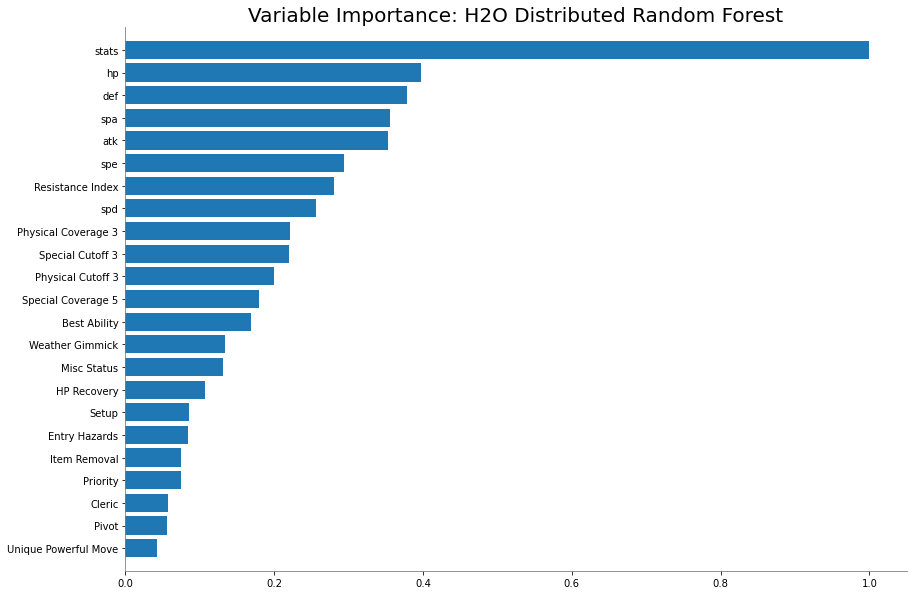

In [59]:
best_model_7_cluster.varimp_plot(23)

So our stats clusters turned out to be the most important feature! This means the h2o library is working in properly prioritizing categorical variables. And for our 7 class models, it does seem that all the features have a decent prioritization, compared to the 2 class models.

#### 2 class with clustering

In [60]:
rf_grid_dict = {}

#sets up the nested dictionary structure
for n in n_clusters:
    rf_grid_dict[n] = {}

for n in n_clusters:
    for c_type in cluster_types:
        #merging the clusters into the data
        X_final = pd.merge(X, cluster_dfs[n][c_type], on='name')
        
        #I don't like the h2o version of train_test_split
        #it doesn't offer stratify, so we're just using sklearn
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
        
        #merging features with target variable since that's the format h2o uses
        data = X_train.merge(y_train, on='name')
        
        #making pokemon name a column so that we can track it later
        #becasue h2o frames don't keep row indexes, they are only numerical
        #it will be dropped during training, after the train test split
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        
        data_h2 = h2o.H2OFrame(data)
        
        #turn the one-hot encoded unique powerful moves, and our target variable...
        #...into categoricals
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats2'] = data_h2['formats2'].asfactor()
        
        rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
        rf_grid.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)
    
        rf_grid_dict[n][c_type] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

In [61]:
best = (0, 0, 0, 0)

for n in n_clusters:
    for c_type in cluster_types:
        count = 0
        ##remake the data_h2 again for each n and c_type
        X_final = pd.merge(X, cluster_dfs[n][c_type], on='name')
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
        data = X_train.merge(y_train, on='name')
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        data_h2 = h2o.H2OFrame(data)
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats2'] = data_h2['formats2'].asfactor()
        for model in rf_grid_dict[n][c_type]:
            data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats2']))[0]
            data_result = data_h2.as_data_frame()
            score = f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')
            if score > best[0]:
                best = (score, n, c_type, count)
            count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9602298479984674, 5, 'stats', 1)

It's funny that my two class models seem to consistently perform worse than the 7 class models, but not by a lot. Stats seems to be the big winner for clusters again, but this time with only 5 clusters, perhaps because the differentiation between two classes takes less nuance than differentiating between 7.

In [62]:
best_model_2_cluster = rf_grid_dict[5]['stats'][1]

##remake the data_h2 again for 5 stats clusters
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

data_h2['prediction'] = best_model_2_cluster.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9602298479984674

In [63]:
rf_grid_dict[5]['stats']

     ntrees  \
0      64.0   
1     128.0   

                                                            model_ids  \
0  Grid_DRF_py_783_sid_8f98_model_python_1640412025079_137580_model_1   
1  Grid_DRF_py_783_sid_8f98_model_python_1640412025079_137580_model_2   

    logloss  
0  0.328658  
1  0.334348  


In [64]:
best_model_2_cluster.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,128.0,128.0,61590.0,7.0,10.0,9.078125,25.0,43.0,33.515625


And just as the 7 class models use 64 trees, the 2 class models consistently use 128 trees! It's strange that they require more complication.

In [65]:
precision_recall_fscore_support(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'])

(array([0.95256917, 0.96666667]),
 array([0.96015936, 0.9602649 ]),
 array([0.95634921, 0.96345515]),
 array([251, 302], dtype=int64))

In [66]:
data_result.loc[data_result['formats2'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,stats,formats2,prediction
12,Beartic,95,130,80,70,80,50,-3,0,0,...,8,5,4,2,0,100.000000,0,2,No,Yes
13,Silvally-Poison,95,95,95,95,95,95,3,0,0,...,7,14,9,4,1,100.000000,0,3,Yes,No
37,Krokorok,60,82,45,45,45,74,6,2,0,...,7,6,4,2,0,75.000000,0,1,Yes,No
49,Ferroseed,44,50,91,24,86,10,11,3,0,...,4,4,3,3,0,80.000000,2,1,Yes,No
58,Dusclops,40,70,130,60,130,25,8,0,0,...,8,8,5,3,0,65.217391,0,0,No,Yes
78,Wishiwashi,45,20,20,25,25,40,2,0,0,...,4,4,3,1,0,1.000000,0,1,Yes,No
84,Regigigas,110,160,110,80,110,100,3,0,0,...,10,4,4,3,0,0.000000,2,3,No,Yes
135,Octillery,75,105,75,105,75,45,2,0,0,...,5,13,8,3,0,50.000000,0,2,No,Yes
147,Gourgeist-Large,75,95,122,58,75,69,7,0,0,...,5,12,9,3,0,50.000000,3,0,No,Yes
162,Exeggutor,95,95,85,125,75,55,-2,0,1,...,4,7,4,4,0,63.636364,3,3,No,Yes


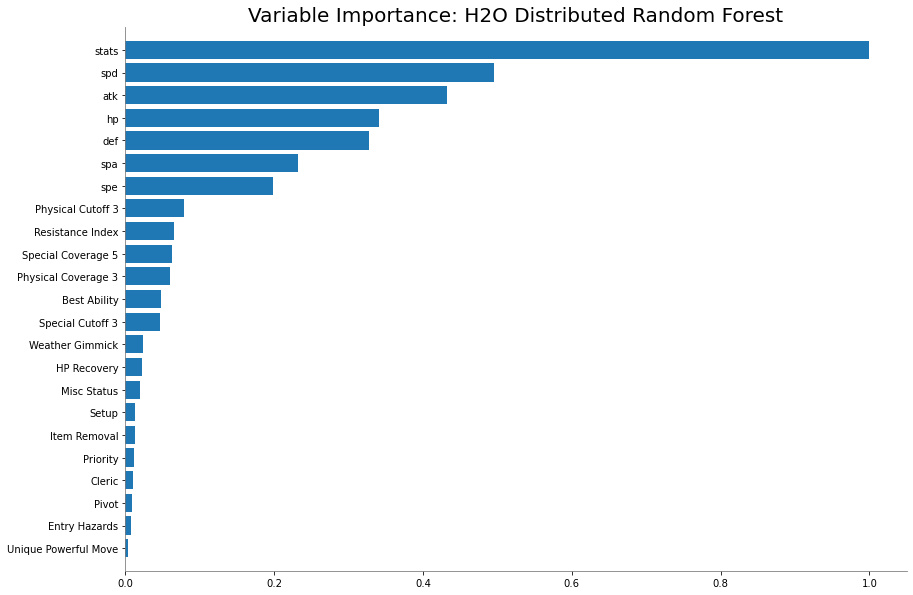

In [67]:
best_model_2_cluster.varimp_plot(23)

And likewise, the stats cluster column performed well again, and the model is heavily weighted towards stats, which tends to happen with the 2 class models

<a id="two_stage_rf"></a>
#### two-stage Random Forest

#### two-stage 7 class, no clusters

Here is the first stage which is just our best performing 2 class model with no clusters:

In [68]:
#I don't like the h2o version of train_test_split
#it doesn't offer stratify, so we're just using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_df['formats2'].values)
    
#merging features with target variable since that's the format h2o uses
data = X_train.merge(y_train, on='name')
    
#making pokemon name a column so that we can track it later
#becasue h2o frames don't keep row indexes, they are only numerical
#it will be dropped during training, after the train test split
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
    
data_h2 = h2o.H2OFrame(data)

#turn the one-hot encoded unique powerful moves, and our target variable...
#...into categoricals
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
first_stage.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9417868312618772

In [69]:
X_second = X.loc[y_df['formats2'] == 'Yes']
X_second

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charizard,78,84,78,109,85,100,8,0,0,0,...,1,3,14,10,11,5,4,0,50.000000,3
Blastoise,79,83,100,85,105,78,2,0,0,3,...,2,2,12,10,11,7,4,0,75.000000,0
Pikachu,35,55,40,50,50,90,2,0,1,3,...,2,2,7,7,5,3,3,0,70.000000,1
Raichu,60,90,55,90,80,110,2,0,1,3,...,2,2,7,7,6,4,3,0,70.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,1,0,...,0,2,3,3,9,4,3,0,18.181818,2


In [70]:
y_second_7 = y_df['formats'].loc[y_df['formats2'] == 'Yes']
y_second_7

name
Venusaur            OU
Charizard           PU
Blastoise           NU
Pikachu             PU
Raichu              PU
                  ... 
Glastrier           NU
Spectrier         Uber
Calyrex             PU
Calyrex-Ice       Uber
Calyrex-Shadow    Uber
Name: formats, Length: 403, dtype: object

In [71]:
#I don't like the h2o version of train_test_split
#it doesn't offer stratify, so we're just using sklearn
X_train, X_test, y_train, y_test = train_test_split(X_second, y_second_7,
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_second_7.values)
    
#merging features with target variable since that's the format h2o uses
data = X_train.merge(y_train, on='name')
    
#making pokemon name a column so that we can track it later
#becasue h2o frames don't keep row indexes, they are only numerical
#it will be dropped during training, after the train test split
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
    
data_h2 = h2o.H2OFrame(data)

#turn the one-hot encoded unique powerful moves, and our target variable...
#...into categoricals
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()
    
rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
rf_grid.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)

best = (0, 0)
count = 0

for model in rf_grid.get_grid():
    data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats']))[0]
    data_result = data_h2.as_data_frame()
    score = f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')
    if score > best[0]:
        best = (score, count)
    count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


(0.9407030090384477, 0)

In [72]:
second_stage = rf_grid.get_grid()[0]
data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9407030090384477

In [73]:
rf_grid.get_grid()

     ntrees  \
0     128.0   
1      64.0   

                                                             model_ids  \
0  Grid_DRF_py_1028_sid_8f98_model_python_1640412025079_160559_model_2   
1  Grid_DRF_py_1028_sid_8f98_model_python_1640412025079_160559_model_1   

    logloss  
0  1.574761  
1  1.577060  


In [74]:
second_stage.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,128.0,768.0,371145.0,7.0,10.0,9.447917,21.0,45.0,33.682293


128 trees won out over 64 trees for the second part of this two-stage 7 class model.

In [75]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.86861314, 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.87096774, 0.85714286, 0.94117647, 0.88372093,
        0.95      ]),
 array([0.9296875 , 0.93103448, 0.92307692, 0.96969697, 0.9382716 ,
        0.97435897]),
 array([119,  31,  35,  34,  43,  40], dtype=int64))

This didn't get 100% on any column, which might be a sign it isn't overfitting as much even though it got very good scores, but let's see what it's getting wrong:

In [76]:
data_result.loc[data_result['formats'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,formats,prediction
8,Toxapex,50,63,152,53,142,35,5,1,0,...,3,2,8,3,4,0,100.000000,4,Uber,PU
25,Barbaracle,72,105,115,54,86,68,1,2,0,...,10,8,9,6,3,0,100.000000,0,RU,PU
26,Gengar,60,65,60,130,75,110,10,0,0,...,8,8,13,9,3,0,71.428571,2,OU,PU
33,Aegislash,60,50,140,50,140,60,18,0,0,...,7,4,4,3,4,0,1.000000,0,OU,PU
72,Arctozolt,90,100,90,90,80,55,-1,0,0,...,10,6,9,4,3,1,100.000000,0,RU,PU
104,Marowak-Alola,60,80,110,50,80,45,11,2,0,...,13,10,15,9,3,1,71.428571,0,RU,PU
115,Zoroark,60,105,60,120,60,105,3,0,0,...,3,4,10,7,3,0,1.000000,0,NU,PU
131,Skarmory,65,80,140,40,70,70,16,3,0,...,6,6,4,2,4,0,57.142857,3,Uber,PU
133,Rotom-Heat,50,65,107,105,107,86,5,0,0,...,2,2,9,6,4,0,95.454545,0,OU,PU
136,Barraskewda,61,123,60,60,50,136,2,0,0,...,8,8,3,2,0,0,66.666667,0,RU,PU


Interestingly, ALL of the wrong answers are predicted incorrectly as PU (which could again be the sign that a 3 stage model might be the way to go!). There were some pretty drastically wrong answers here though:
- Toxapex (Uber), Gengar (OU), Aegislash (OU), Skarmory (Uber), Rotom-Heat (OU), Crawdaunt (OU), Alakazam (OU), and arguably more besides

Some of these defensive more powerful pokemon, or those that rely on hack-like strategies, might be more difficult for the model to detect as being conventionally powerful.

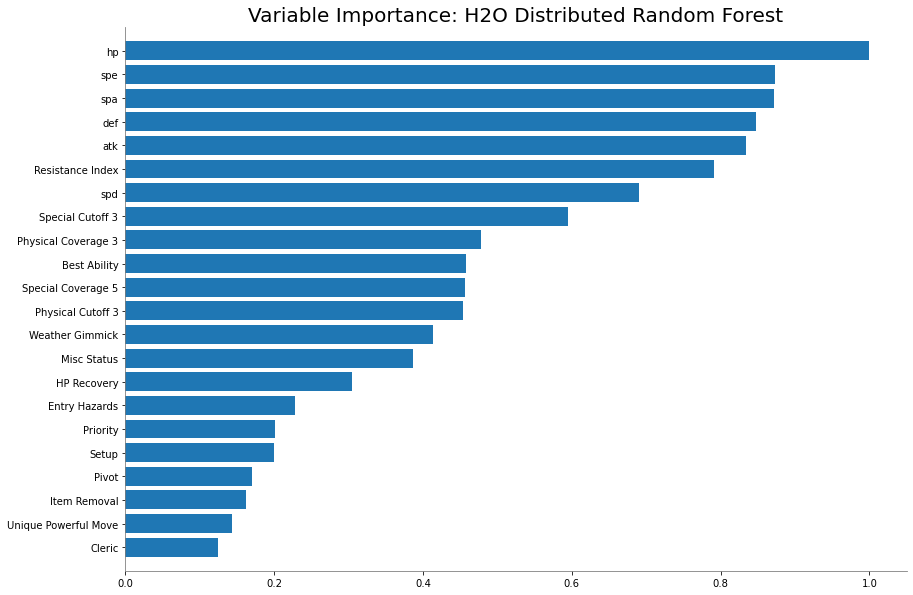

In [77]:
second_stage.varimp_plot(22)

This is actually another very balanced looking model, like the previous 7 class models, which is promising.

In [78]:
#Setting up the 2 class data for stage 1
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

pred_1 = data_h2['name']
pred_1['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats2'])[pred_1_mask, :])[0]

y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')['prediction_y'].fillna(value='ZU')

#this step is important to get formats in the same order as the training data
y_validation = y_train.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Absol              PU
Ninetales-Alola    OU
Palossand          PU
Ponyta-Galar       ZU
Carvanha           ZU
                   ..
Dragonair          ZU
Qwilfish           PU
Cryogonal          PU
Wailord            ZU
Blaziken           OU
Name: formats, Length: 553, dtype: object

In [79]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.8678262088232164

In [80]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.98237885, 0.65240642, 1.        , 1.        , 0.96551724,
        0.96551724, 0.85294118]),
 array([0.88844622, 0.96062992, 0.7       , 0.76470588, 0.82352941,
        0.68292683, 0.80555556]),
 array([0.93305439, 0.77707006, 0.82352941, 0.86666667, 0.88888889,
        0.8       , 0.82857143]),
 array([251, 127,  30,  34,  34,  41,  36], dtype=int64))

These scores are not as good as our one-stage model, especially struggling with the PU class and throwing too much in there, but it's hard for me to say that the two-stage model is definitely worse since overfitting can be such a large issue.

<a id="two_stage_rf_cluster"></a>
#### two-stage Random Forest with clustering

#### two-stage 7 class with clustering

We need to set it up so that our first stage has clustering now:

In [81]:
##remake the data_h2 again for 5 stats clusters
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
first_stage.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9602298479984674

Now we need to select the parameters for our second-stage model with 6 classes:

In [82]:
rf_grid_dict = {}

#sets up the nested dictionary structure
for n in n_clusters:
    rf_grid_dict[n] = {}

for n in n_clusters:
    for c_type in cluster_types:
        #merging the clusters into the data
        X_final = pd.merge(X_second, cluster_dfs[n][c_type], on='name')
        
        #I don't like the h2o version of train_test_split
        #it doesn't offer stratify, so we're just using sklearn
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
        
        #merging features with target variable since that's the format h2o uses
        data = X_train.merge(y_train, on='name')
        
        #making pokemon name a column so that we can track it later
        #becasue h2o frames don't keep row indexes, they are only numerical
        #it will be dropped during training, after the train test split
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        
        data_h2 = h2o.H2OFrame(data)
        
        #turn the one-hot encoded unique powerful moves, and our target variable...
        #...into categoricals
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        
        rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
        rf_grid.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)
    
        rf_grid_dict[n][c_type] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

In [83]:
best = (0, 0, 0, 0)

for n in n_clusters:
    for c_type in cluster_types:
        count = 0
        ##remake the data_h2 again for each n and c_type
        X_final = pd.merge(X_second, cluster_dfs[n][c_type], on='name')
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
        data = X_train.merge(y_train, on='name')
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        data_h2 = h2o.H2OFrame(data)
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        for model in rf_grid_dict[n][c_type]:
            data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats']))[0]
            data_result = data_h2.as_data_frame()
            score = f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')
            if score > best[0]:
                best = (score, n, c_type, count)
            count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9635991571674135, 15, 'learnsets', 0)

Interesting that learnset clusters are winning out for the first time when working with h2o random forest (instead of stats)

In [84]:
second_stage = rf_grid_dict[15]['learnsets'][0]

##remake the data_h2 again for 15 learnsets clusters
X_final = pd.merge(X_second, cluster_dfs[15]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9635991571674135

In [85]:
rf_grid_dict[15]['learnsets']

     ntrees  \
0     128.0   
1      64.0   

                                                             model_ids  \
0  Grid_DRF_py_1082_sid_8f98_model_python_1640412025079_161217_model_2   
1  Grid_DRF_py_1082_sid_8f98_model_python_1640412025079_161217_model_1   

    logloss  
0  1.585276  
1  1.721133  


In [86]:
second_stage.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,128.0,768.0,362086.0,6.0,10.0,9.194011,22.0,44.0,32.76953


Again we have 128 trees winning out, which has generally coincided with models that are more weighted towards the "stats", but we'll see what happens in this case:

In [87]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.91538462, 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.87096774, 0.97142857, 0.94117647, 0.93023256,
        0.975     ]),
 array([0.95582329, 0.93103448, 0.98550725, 0.96969697, 0.96385542,
        0.98734177]),
 array([119,  31,  35,  34,  43,  40], dtype=int64))

It looks like yet again it struggled with the PU class, because it's getting a high recall on PU, but low precision since it assigns PU to some pokemon that are much higher, exactly like the last two-stage model did.

In [88]:
data_result.loc[data_result['formats'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,learnsets,formats,prediction
23,Reuniclus,110,65,75,125,85,30,-1,0,0,...,8,11,7,3,0,100.000000,4,13,UU,PU
26,Gengar,60,65,60,130,75,110,10,0,0,...,8,13,9,3,0,71.428571,2,6,OU,PU
115,Zoroark,60,105,60,120,60,105,3,0,0,...,4,10,7,3,0,1.000000,0,14,NU,PU
131,Skarmory,65,80,140,40,70,70,16,3,0,...,6,4,2,4,0,57.142857,3,3,Uber,PU
133,Rotom-Heat,50,65,107,105,107,86,5,0,0,...,2,9,6,4,0,95.454545,0,12,OU,PU
136,Barraskewda,61,123,60,60,50,136,2,0,0,...,8,3,2,0,0,66.666667,0,0,RU,PU
216,Polteageist,60,65,65,134,114,70,8,0,1,...,3,6,4,3,0,71.428571,4,0,UU,PU
223,Alakazam,55,50,45,135,95,120,-1,0,0,...,9,11,7,3,0,100.000000,3,13,OU,PU
267,Raichu-Alola,60,85,50,95,85,110,1,0,1,...,7,10,5,3,0,1.000000,1,8,NU,PU
271,Silvally-Ground,95,95,95,95,95,95,3,0,0,...,7,14,9,4,1,100.000000,0,7,NU,PU


This time the only one's that are WAY off are Gengar, Skarmory, Rotom-Heat and Alakazam, and there is definitely a lot less wrong than the previous model so the clustering model is probably superior, but the continuing of the same general trends in the modeling failures doesn't give me much hope for this two-stage model either.

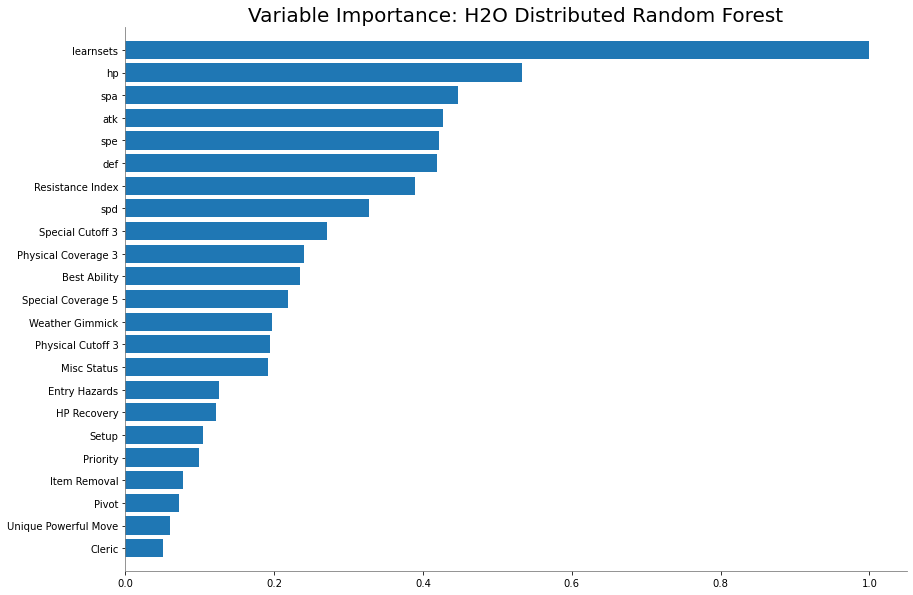

In [89]:
second_stage.varimp_plot(23)

This model is also relatively balanced but also highly biased towards the clusters, which in this case are based on the learnsets, which is very interesting.

In [90]:
#Setting up the 2 class data for stage 1
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_final = pd.merge(X_final, cluster_dfs[15]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

pred_1 = data_h2['name']
pred_1['prediction'] = first_stage.predict(data_h2.drop(['name', 'learnsets', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2.drop(['name', 'stats', 'formats2'])[pred_1_mask, :])[0]

y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')['prediction_y'].fillna(value='ZU')

#this step is important to get formats in the same order as the training data
y_validation = y_train.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Absol              PU
Ninetales-Alola    OU
Palossand          PU
Ponyta-Galar       ZU
Carvanha           ZU
                   ..
Dragonair          ZU
Qwilfish           PU
Cryogonal          PU
Wailord            ZU
Blaziken           OU
Name: formats, Length: 553, dtype: object

In [91]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.8870641962215188

In [92]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.95256917, 0.72727273, 0.95454545, 0.96551724, 0.96551724,
        0.96774194, 0.85714286]),
 array([0.96015936, 0.88188976, 0.7       , 0.82352941, 0.82352941,
        0.73170732, 0.83333333]),
 array([0.95634921, 0.79715302, 0.80769231, 0.88888889, 0.88888889,
        0.83333333, 0.84507042]),
 array([251, 127,  30,  34,  34,  41,  36], dtype=int64))

This is basically a slightly superior model in comparison to the two-stage model that doesn't use clusters.

Notebook runtime: about 20 minutes on my computer

<a id="performance"></a>
## Score Summary:

### one-stage, no clusters

#### 7 classes, no clusters
0.9580047843741822\
[0.95938104, 0.9122807, 0.94915254, 0.98550725, 1., 0.98823529, 1.]

#### 2 class no clusters
0.9417868312618772\
[0.93305439, 0.94904459]

### one-stage, with clustering

#### 7 class with clustering
0.972750638800639\
[0.97254902, 0.94420601, 0.96666667, 1., 1., 0.98823529, 1.]

#### 2 class with clustering
0.9602298479984674\
[0.95634921, 0.96345515]

### two-stage, no clustering

#### two-stage 7 class, no clusters
0.8678262088232164\
[0.93305439, 0.77707006, 0.82352941, 0.86666667, 0.88888889, 0.8, 0.82857143]

### two-stage, with clustering

#### two-stage 7 class with clustering
0.8870641962215188\
[0.95634921, 0.79715302, 0.80769231, 0.88888889, 0.88888889, 0.83333333, 0.84507042]

## Performance Summary

Since there are only 4 real models in this case (the 2 stage one's are just being built to support the two-stage 7 class models), and because these models all perform quite well, we are going to check the results of all 4 of these models on the test set to check how they handle overfitting.

## Explainability Summary

These Random Forest aren't as easily interpretable as Decision Trees, since the fact that there are so many trees in each model makes them relatively opaque (similar to a neural network). However, since they have feature importances, they are comparably explainable to logistic regression and more easily explainable than KNN which pretty much isn't even a "model".